In [31]:
%pip install numpy pandas seaborn matplotlib 


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [32]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from math import log
import subprocess

num_steps_users = 12  # Number of steps for users
num_steps_sizes = 24  # Number of steps for payload sizes
run_time_seconds = 30  # Number of seconds to run each test
num_workers = 4 # Number of workers to use for each test

num_users_list = np.array([20])
payload_sizes = np.unique(np.logspace(0, 20, num=num_steps_sizes, base=2).astype(int))  # Logarithmically spaced sizes, ensure unique values


# fix user, small files between 1byte and 100kb
#min_size_log2 = 0  # log2(1 byte)
#max_size_log2 = log(100 * 1024, 2)  # log2(100 KB)
#num_steps_sizes = 32  # Number of steps for payload sizes
#payload_sizes = np.unique(np.logspace(min_size_log2, max_size_log2, num=num_steps_sizes, base=2).astype(int))
#num_users_list = np.full(1, 500)

In [33]:

tasks = []
for payload_size in payload_sizes:
    for num_users in num_users_list:
        task = {
            "num_users": num_users,
            "spawn_rate": num_users,  # Adjust as needed
            "payload_size": payload_size,
            "csv_filename": f"results_{payload_size}_{num_users}"
        }
        tasks.append(task)

# View first 5 tasks as an example
tasks_df = pd.DataFrame(tasks)

pd.set_option('display.max_rows', None)
print(tasks_df)
pd.reset_option('display.max_rows')


    num_users  spawn_rate  payload_size        csv_filename
0          20          20             1        results_1_20
1          20          20             3        results_3_20
2          20          20             6        results_6_20
3          20          20            11       results_11_20
4          20          20            20       results_20_20
5          20          20            37       results_37_20
6          20          20            67       results_67_20
7          20          20           124      results_124_20
8          20          20           226      results_226_20
9          20          20           414      results_414_20
10         20          20           757      results_757_20
11         20          20          1384     results_1384_20
12         20          20          2528     results_2528_20
13         20          20          4620     results_4620_20
14         20          20          8442     results_8442_20
15         20          20         15425 

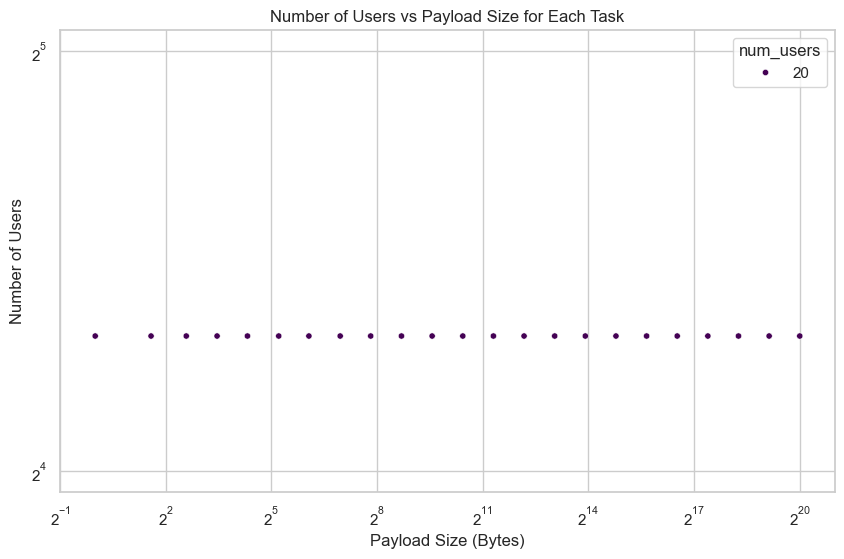

In [34]:
# Set the aesthetics for the plot
sns.set(style="whitegrid")

# Create the scatter plot
plt.figure(figsize=(10, 6))
ax = sns.scatterplot(data=tasks_df, x='payload_size', y='num_users', size='num_users', hue='num_users', palette='viridis', sizes=(20, 200))

# Set the scale of the x/y-axis to logarithmic to better visualize the data
ax.set_xscale('log', base=2)
ax.set_yscale('log', base=2)

# Set plot labels and title
ax.set_xlabel('Payload Size (Bytes)')
ax.set_ylabel('Number of Users')
ax.set_title('Number of Users vs Payload Size for Each Task')

# Show the plot
plt.show()

In [35]:
def run_benchmark_docker(task):
    results_file_path = f"results/{task['csv_filename']}"

    # Check if the results file already exists
    if os.path.exists(f".{results_file_path}_stats.csv"):
        print(f"Skipping benchmark for task: {task} as results already exist.")
        return
    
    # Set environment variables
    os.environ['NUM_USERS'] = str(task['num_users'])
    os.environ['SPAWN_RATE'] = str(task['spawn_rate'])
    os.environ['RUN_TIME'] = str(run_time_seconds)
    os.environ['CSV_FILENAME'] = results_file_path
    os.environ['PAYLOAD_SIZE'] = str(task['payload_size'])
    os.environ['NUM_WORKERS'] = str(num_workers)
    
    # Run the benchmark using Docker Compose
    subprocess.run(["docker", "compose", "up", "--scale", f"locust-worker={num_workers}"], check=True)

    # Optionally, you can stop and remove containers if needed
    subprocess.run(["docker-compose", "down"], check=True)


# Ensure the results directory exists
os.makedirs('.results', exist_ok=True)

#for task in tasks:
#    run_benchmark_docker(task)

In [36]:
def run_benchmark_local(task):
    results_file_path = f".results/{task['csv_filename']}"

    # Check if the results file already exists
    if os.path.exists(f"{results_file_path}_stats.csv"):
        print(f"Skipping benchmark for task: {task} as results already exist.")
        return
    
    os.environ['PAYLOAD_SIZE'] = str(task['payload_size'])
    os.environ['NUM_WORKERS'] = str(num_workers)
    
    # Command to start the Locust master
    master_command = ["locust", "-f", "../locust/locustfile.py", "--master", "--headless", 
                      "--expect-workers", "4",
                      "--host", "http://192.168.1.105:8000", 
                      "-u", str(task['num_users']), 
                      "-r", str(task['spawn_rate']), 
                      "--run-time", str(run_time_seconds),
                      "--csv", results_file_path]

    # Commands to start Locust workers
    worker_commands = [
        ["locust", "-f", "../locust/locustfile.py", "--worker", "--master-host", "127.0.0.1"] for _ in range(num_workers)
    ]

    # Start the Locust master
    master_process = subprocess.Popen(master_command)

    # Start the worker processes
    worker_processes = [subprocess.Popen(cmd) for cmd in worker_commands]
    
    try:
        # Wait for the master process to complete
        master_process.wait()
    except KeyboardInterrupt:
        # Handle Ctrl+C
        pass
    finally:
        # Terminate all processes
        master_process.terminate()
        for worker in worker_processes:
            worker.terminate()


# Ensure the results directory exists
os.makedirs('.results', exist_ok=True)

for task in tasks:
    run_benchmark_local(task)

payload_size: 1payload_size: 1payload_size: 1


payload_size: 1
payload_size: 1


[2023-11-12 23:35:12,259] BUD-MAC-16300-(26473)/INFO/root: Waiting for workers to be ready, 0 of 4 connected
Type     Name                                                                          # reqs      # fails |    Avg     Min     Max    Med |   req/s  failures/s
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
         Aggregated                                                                         0     0(0.00%) |      0       0       0      0 |    0.00        0.00

[2023-11-12 23:35:12,264] BUD-MAC-16300-(26473)/INFO/locust.runners: Worker BUD-MAC-16300-(26473)_2601dd55ec514dc9868e844c80d940de (index 0) reported as ready. 1 workers connected.
[2023-11-12 23:35:12,264] BUD-MAC-16300-(26473)/INFO/locust.runne

payload_size: 3payload_size: 3

payload_size: 3
payload_size: 3
payload_size: 3


[2023-11-12 23:35:45,407] BUD-MAC-16300-(26473)/INFO/root: Waiting for workers to be ready, 0 of 4 connected
Type     Name                                                                          # reqs      # fails |    Avg     Min     Max    Med |   req/s  failures/s
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
         Aggregated                                                                         0     0(0.00%) |      0       0       0      0 |    0.00        0.00

[2023-11-12 23:35:45,411] BUD-MAC-16300-(26473)/INFO/locust.runners: Worker BUD-MAC-16300-(26473)_4cc637862a10439282f34b2b07a25516 (index 0) reported as ready. 1 workers connected.
[2023-11-12 23:35:45,411] BUD-MAC-16300-(26473)/INFO/locust.runne

payload_size: 6
payload_size: 6
payload_size: 6
payload_size: 6
payload_size: 6


[2023-11-12 23:36:18,573] BUD-MAC-16300-(26473)/INFO/root: Waiting for workers to be ready, 0 of 4 connected
Type     Name                                                                          # reqs      # fails |    Avg     Min     Max    Med |   req/s  failures/s
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
         Aggregated                                                                         0     0(0.00%) |      0       0       0      0 |    0.00        0.00

[2023-11-12 23:36:18,576] BUD-MAC-16300-(26473)/INFO/locust.runners: Worker BUD-MAC-16300-(26473)_a74079e2566f46e4b253d6d496533423 (index 0) reported as ready. 1 workers connected.
[2023-11-12 23:36:18,576] BUD-MAC-16300-(26473)/INFO/locust.runne

payload_size: 11
payload_size: 11
payload_size: 11
payload_size: 11
payload_size: 11


[2023-11-12 23:36:51,724] BUD-MAC-16300-(26473)/INFO/root: Waiting for workers to be ready, 0 of 4 connected
Type     Name                                                                          # reqs      # fails |    Avg     Min     Max    Med |   req/s  failures/s
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
         Aggregated                                                                         0     0(0.00%) |      0       0       0      0 |    0.00        0.00

[2023-11-12 23:36:51,731] BUD-MAC-16300-(26473)/INFO/locust.runners: Worker BUD-MAC-16300-(26473)_7ee116515d924025b9ac3a1a00de7ed6 (index 0) reported as ready. 1 workers connected.
[2023-11-12 23:36:51,732] BUD-MAC-16300-(26473)/INFO/locust.runne

payload_size: 20
payload_size: 20
payload_size: 20
payload_size: 20
payload_size: 20


[2023-11-12 23:37:24,880] BUD-MAC-16300-(26473)/INFO/root: Waiting for workers to be ready, 0 of 4 connected
Type     Name                                                                          # reqs      # fails |    Avg     Min     Max    Med |   req/s  failures/s
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
         Aggregated                                                                         0     0(0.00%) |      0       0       0      0 |    0.00        0.00

[2023-11-12 23:37:24,883] BUD-MAC-16300-(26473)/INFO/locust.runners: Worker BUD-MAC-16300-(26473)_bd7d7ad7e12e47b9ae291a886092dc8d (index 0) reported as ready. 1 workers connected.
[2023-11-12 23:37:24,884] BUD-MAC-16300-(26473)/INFO/locust.main:

payload_size: 37
payload_size: 37
payload_size: 37
payload_size: 37
payload_size: 37


[2023-11-12 23:37:58,040] BUD-MAC-16300-(26473)/INFO/root: Waiting for workers to be ready, 0 of 4 connected
Type     Name                                                                          # reqs      # fails |    Avg     Min     Max    Med |   req/s  failures/s
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
         Aggregated                                                                         0     0(0.00%) |      0       0       0      0 |    0.00        0.00

[2023-11-12 23:37:58,043] BUD-MAC-16300-(26473)/INFO/locust.runners: Worker BUD-MAC-16300-(26473)_2fc168ae6ab04f8cb3c751328280c755 (index 0) reported as ready. 1 workers connected.
[2023-11-12 23:37:58,045] BUD-MAC-16300-(26473)/INFO/locust.main:

payload_size: 67
payload_size: 67
payload_size: 67
payload_size: 67
payload_size: 67


[2023-11-12 23:38:31,206] BUD-MAC-16300-(26473)/INFO/root: Waiting for workers to be ready, 0 of 4 connected
[2023-11-12 23:38:31,208] BUD-MAC-16300-(26473)/INFO/locust.runners: Worker BUD-MAC-16300-(26473)_071aef665d9d42f4a318fe444e441ec7 (index 0) reported as ready. 1 workers connected.
[2023-11-12 23:38:31,209] BUD-MAC-16300-(26473)/INFO/locust.runners: Worker BUD-MAC-16300-(26473)_e039dc57b60744778bc3f334019fa240 (index 1) reported as ready. 2 workers connected.
Type     Name                                                                          # reqs      # fails |    Avg     Min     Max    Med |   req/s  failures/s
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
         Aggregated                           

payload_size: 124
payload_size: 124
payload_size: 124
payload_size: 124
payload_size: 124


[2023-11-12 23:39:04,364] BUD-MAC-16300-(26473)/INFO/root: Waiting for workers to be ready, 0 of 4 connected
Type     Name                                                                          # reqs      # fails |    Avg     Min     Max    Med |   req/s  failures/s
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
         Aggregated                                                                         0     0(0.00%) |      0       0       0      0 |    0.00        0.00

[2023-11-12 23:39:04,367] BUD-MAC-16300-(26473)/INFO/locust.runners: Worker BUD-MAC-16300-(26473)_07544a80a54043fdbb26857862e4737f (index 0) reported as ready. 1 workers connected.
[2023-11-12 23:39:04,367] BUD-MAC-16300-(26473)/INFO/locust.runne

payload_size: 226
payload_size: 226
payload_size: 226
payload_size: 226
payload_size: 226


[2023-11-12 23:39:37,525] BUD-MAC-16300-(26473)/INFO/root: Waiting for workers to be ready, 0 of 4 connected
Type     Name                                                                          # reqs      # fails |    Avg     Min     Max    Med |   req/s  failures/s
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
         Aggregated                                                                         0     0(0.00%) |      0       0       0      0 |    0.00        0.00

[2023-11-12 23:39:37,528] BUD-MAC-16300-(26473)/INFO/locust.runners: Worker BUD-MAC-16300-(26473)_e45d757704dd48fa962e38d787fb1801 (index 0) reported as ready. 1 workers connected.
[2023-11-12 23:39:37,530] BUD-MAC-16300-(26473)/INFO/locust.main:

payload_size: 414
payload_size: 414
payload_size: 414
payload_size: 414
payload_size: 414


[2023-11-12 23:40:10,721] BUD-MAC-16300-(26473)/INFO/root: Waiting for workers to be ready, 0 of 4 connected
[2023-11-12 23:40:10,723] BUD-MAC-16300-(26473)/INFO/locust.runners: Worker BUD-MAC-16300-(26473)_26bdd3cb77124296bbc9ce03d495b17f (index 0) reported as ready. 1 workers connected.
Type     Name                                                                          # reqs      # fails |    Avg     Min     Max    Med |   req/s  failures/s
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
         Aggregated                                                                         0     0(0.00%) |      0       0       0      0 |    0.00        0.00

[2023-11-12 23:40:10,724] BUD-MAC-16300-(26473)/INFO/locust.main:

payload_size: 757
payload_size: 757
payload_size: 757
payload_size: 757
payload_size: 757


[2023-11-12 23:40:43,864] BUD-MAC-16300-(26473)/INFO/root: Waiting for workers to be ready, 0 of 4 connected
Type     Name                                                                          # reqs      # fails |    Avg     Min     Max    Med |   req/s  failures/s
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
         Aggregated                                                                         0     0(0.00%) |      0       0       0      0 |    0.00        0.00

[2023-11-12 23:40:43,869] BUD-MAC-16300-(26473)/INFO/locust.runners: Worker BUD-MAC-16300-(26473)_ae355fd8dc1745d684b958807666fb99 (index 0) reported as ready. 1 workers connected.
[2023-11-12 23:40:43,869] BUD-MAC-16300-(26473)/INFO/locust.runne

payload_size: 1384
payload_size: 1384
payload_size: 1384
payload_size: 1384
payload_size: 1384


[2023-11-12 23:41:17,036] BUD-MAC-16300-(26473)/INFO/root: Waiting for workers to be ready, 0 of 4 connected
Type     Name                                                                          # reqs      # fails |    Avg     Min     Max    Med |   req/s  failures/s
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
         Aggregated                                                                         0     0(0.00%) |      0       0       0      0 |    0.00        0.00

[2023-11-12 23:41:17,039] BUD-MAC-16300-(26473)/INFO/locust.runners: Worker BUD-MAC-16300-(26473)_f5429930df484660a132acd87a033115 (index 0) reported as ready. 1 workers connected.
[2023-11-12 23:41:17,040] BUD-MAC-16300-(26473)/INFO/locust.runne

payload_size: 2528
payload_size: 2528
payload_size: 2528
payload_size: 2528
payload_size: 2528


[2023-11-12 23:41:50,261] BUD-MAC-16300-(26473)/INFO/root: Waiting for workers to be ready, 0 of 4 connected
Type     Name                                                                          # reqs      # fails |    Avg     Min     Max    Med |   req/s  failures/s
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
         Aggregated                                                                         0     0(0.00%) |      0       0       0      0 |    0.00        0.00

[2023-11-12 23:41:50,264] BUD-MAC-16300-(26473)/INFO/locust.runners: Worker BUD-MAC-16300-(26473)_9b5e1f9fe035439bb362deb967619f5c (index 0) reported as ready. 1 workers connected.
[2023-11-12 23:41:50,264] BUD-MAC-16300-(26473)/INFO/locust.runne

payload_size: 4620
payload_size: 4620
payload_size: 4620
payload_size: 4620
payload_size: 4620


[2023-11-12 23:42:23,797] BUD-MAC-16300-(26473)/INFO/root: Waiting for workers to be ready, 0 of 4 connected
Type     Name                                                                          # reqs      # fails |    Avg     Min     Max    Med |   req/s  failures/s
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
         Aggregated                                                                         0     0(0.00%) |      0       0       0      0 |    0.00        0.00

[2023-11-12 23:42:23,803] BUD-MAC-16300-(26473)/INFO/locust.runners: Worker BUD-MAC-16300-(26473)_3317eb7e868a4c35b1d80d62577365f0 (index 0) reported as ready. 1 workers connected.
[2023-11-12 23:42:23,803] BUD-MAC-16300-(26473)/INFO/locust.runne

payload_size: 8442
payload_size: 8442
payload_size: 8442payload_size: 8442payload_size: 8442




[2023-11-12 23:42:57,217] BUD-MAC-16300-(26473)/INFO/root: Waiting for workers to be ready, 0 of 4 connected
Type     Name                                                                          # reqs      # fails |    Avg     Min     Max    Med |   req/s  failures/s
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
         Aggregated                                                                         0     0(0.00%) |      0       0       0      0 |    0.00        0.00

[2023-11-12 23:42:57,221] BUD-MAC-16300-(26473)/INFO/locust.runners: Worker BUD-MAC-16300-(26473)_04a224404c2948b7b4f66390a47c543c (index 0) reported as ready. 1 workers connected.
[2023-11-12 23:42:57,221] BUD-MAC-16300-(26473)/INFO/locust.runne

payload_size: 15425
payload_size: 15425
payload_size: 15425
payload_size: 15425
payload_size: 15425


[2023-11-12 23:43:30,417] BUD-MAC-16300-(26473)/INFO/root: Waiting for workers to be ready, 0 of 4 connected
Type     Name                                                                          # reqs      # fails |    Avg     Min     Max    Med |   req/s  failures/s
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
         Aggregated                                                                         0     0(0.00%) |      0       0       0      0 |    0.00        0.00

[2023-11-12 23:43:30,421] BUD-MAC-16300-(26473)/INFO/locust.runners: Worker BUD-MAC-16300-(26473)_9f90f9c32d6a43ec8f3d2ccf6d350633 (index 0) reported as ready. 1 workers connected.
[2023-11-12 23:43:30,422] BUD-MAC-16300-(26473)/INFO/locust.runne

payload_size: 28184
payload_size: 28184
payload_size: 28184
payload_size: 28184
payload_size: 28184


[2023-11-12 23:44:03,603] BUD-MAC-16300-(26473)/INFO/root: Waiting for workers to be ready, 0 of 4 connected
Type     Name                                                                          # reqs      # fails |    Avg     Min     Max    Med |   req/s  failures/s
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
         Aggregated                                                                         0     0(0.00%) |      0       0       0      0 |    0.00        0.00

[2023-11-12 23:44:03,606] BUD-MAC-16300-(26473)/INFO/locust.runners: Worker BUD-MAC-16300-(26473)_25ef3b45744b451faff891b5f9ede998 (index 0) reported as ready. 1 workers connected.
[2023-11-12 23:44:03,608] BUD-MAC-16300-(26473)/INFO/locust.main:

payload_size: 51496
payload_size: 51496
payload_size: 51496
payload_size: 51496
payload_size: 51496


[2023-11-12 23:44:36,863] BUD-MAC-16300-(26473)/INFO/root: Waiting for workers to be ready, 0 of 4 connected
Type     Name                                                                          # reqs      # fails |    Avg     Min     Max    Med |   req/s  failures/s
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
         Aggregated                                                                         0     0(0.00%) |      0       0       0      0 |    0.00        0.00

[2023-11-12 23:44:36,867] BUD-MAC-16300-(26473)/INFO/locust.runners: Worker BUD-MAC-16300-(26473)_f9855096006249dbb7787273616155c0 (index 0) reported as ready. 1 workers connected.
[2023-11-12 23:44:36,867] BUD-MAC-16300-(26473)/INFO/locust.runne

payload_size: 94089
payload_size: 94089
payload_size: 94089
payload_size: 94089
payload_size: 94089


[2023-11-12 23:45:10,020] BUD-MAC-16300-(26473)/INFO/root: Waiting for workers to be ready, 0 of 4 connected
Type     Name                                                                          # reqs      # fails |    Avg     Min     Max    Med |   req/s  failures/s
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
         Aggregated                                                                         0     0(0.00%) |      0       0       0      0 |    0.00        0.00

[2023-11-12 23:45:10,023] BUD-MAC-16300-(26473)/INFO/locust.runners: Worker BUD-MAC-16300-(26473)_86eeaaf0cec649969580190782d71853 (index 0) reported as ready. 1 workers connected.
[2023-11-12 23:45:10,024] BUD-MAC-16300-(26473)/INFO/locust.runne

payload_size: 171911payload_size: 171911

payload_size: 171911
payload_size: 171911
payload_size: 171911


[2023-11-12 23:45:43,185] BUD-MAC-16300-(26473)/INFO/root: Waiting for workers to be ready, 0 of 4 connected
Type     Name                                                                          # reqs      # fails |    Avg     Min     Max    Med |   req/s  failures/s
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
         Aggregated                                                                         0     0(0.00%) |      0       0       0      0 |    0.00        0.00

[2023-11-12 23:45:43,187] BUD-MAC-16300-(26473)/INFO/locust.runners: Worker BUD-MAC-16300-(26473)_134957b32aa14011b9dbead4fc07c439 (index 0) reported as ready. 1 workers connected.
[2023-11-12 23:45:43,189] BUD-MAC-16300-(26473)/INFO/locust.main:

payload_size: 314101
payload_size: 314101
payload_size: 314101
payload_size: 314101
payload_size: 314101


[2023-11-12 23:46:16,330] BUD-MAC-16300-(26473)/INFO/root: Waiting for workers to be ready, 0 of 4 connected
Type     Name                                                                          # reqs      # fails |    Avg     Min     Max    Med |   req/s  failures/s
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
         Aggregated                                                                         0     0(0.00%) |      0       0       0      0 |    0.00        0.00

[2023-11-12 23:46:16,335] BUD-MAC-16300-(26473)/INFO/locust.runners: Worker BUD-MAC-16300-(26473)_987a4605101c4f548344310661bd8d2b (index 0) reported as ready. 1 workers connected.
[2023-11-12 23:46:16,337] BUD-MAC-16300-(26473)/INFO/locust.runne

payload_size: 573897
payload_size: 573897
payload_size: 573897
payload_size: 573897
payload_size: 573897


[2023-11-12 23:46:49,482] BUD-MAC-16300-(26473)/INFO/root: Waiting for workers to be ready, 0 of 4 connected
[2023-11-12 23:46:49,484] BUD-MAC-16300-(26473)/INFO/locust.runners: Worker BUD-MAC-16300-(26473)_a2536a5e9847416f9351ad1718bda70e (index 0) reported as ready. 1 workers connected.
Type     Name                                                                          # reqs      # fails |    Avg     Min     Max    Med |   req/s  failures/s
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
         Aggregated                                                                         0     0(0.00%) |      0       0       0      0 |    0.00        0.00

[2023-11-12 23:46:49,486] BUD-MAC-16300-(26473)/INFO/locust.main:

payload_size: 1048576
payload_size: 1048576
payload_size: 1048576
payload_size: 1048576
payload_size: 1048576


[2023-11-12 23:47:22,640] BUD-MAC-16300-(26473)/INFO/root: Waiting for workers to be ready, 0 of 4 connected
Type     Name                                                                          # reqs      # fails |    Avg     Min     Max    Med |   req/s  failures/s
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
--------|----------------------------------------------------------------------------|-------|-------------|-------|-------|-------|-------|--------|-----------
         Aggregated                                                                         0     0(0.00%) |      0       0       0      0 |    0.00        0.00

[2023-11-12 23:47:22,644] BUD-MAC-16300-(26473)/INFO/locust.runners: Worker BUD-MAC-16300-(26473)_dda5d2219c3848019ca1fc2eb4f113d3 (index 0) reported as ready. 1 workers connected.
[2023-11-12 23:47:22,644] BUD-MAC-16300-(26473)/INFO/locust.runne

In [37]:
results = []
for task in tasks:
    csv_filename = f".results/{task['csv_filename']}_stats.csv"
    try:
        df = pd.read_csv(csv_filename)
        if not df.empty:
            agg_row = df.iloc[-1]  # Select the last row
            if agg_row["Name"] == "Aggregated":
                results.append({
                    "payload_size": task["payload_size"],
                    "num_users": task["num_users"],
                    "total_requests": int(agg_row["Request Count"]),
                    "avg_response_time": float(agg_row["Average Response Time"]),
                    "med_response_time": float(agg_row["Median Response Time"]),
                })
            else:
                print(f"No aggregated data found in {csv_filename}")
        else:
            print(f"The CSV file is empty: {csv_filename}")
    except FileNotFoundError:
        print(f"Results not found for task: {task}")
    except Exception as e:
        print(f"An error occurred for task {task}: {str(e)}")

results_df = pd.DataFrame(results)
pd.set_option('display.max_rows', None)
print(results_df)
pd.reset_option('display.max_rows')


    payload_size  num_users  total_requests  avg_response_time  \
0              1         20            6158          94.183079   
1              3         20            6147          88.106355   
2              6         20            6164          92.136772   
3             11         20            6119          89.426741   
4             20         20            6108          96.296184   
5             37         20            6059          83.505396   
6             67         20            6069          98.303394   
7            124         20            6097          92.982730   
8            226         20            6045          98.669218   
9            414         20            6032          98.105301   
10           757         20            6008          96.790441   
11          1384         20            6132          97.403932   
12          2528         20            5962          97.235908   
13          4620         20            5930          97.906752   
14        

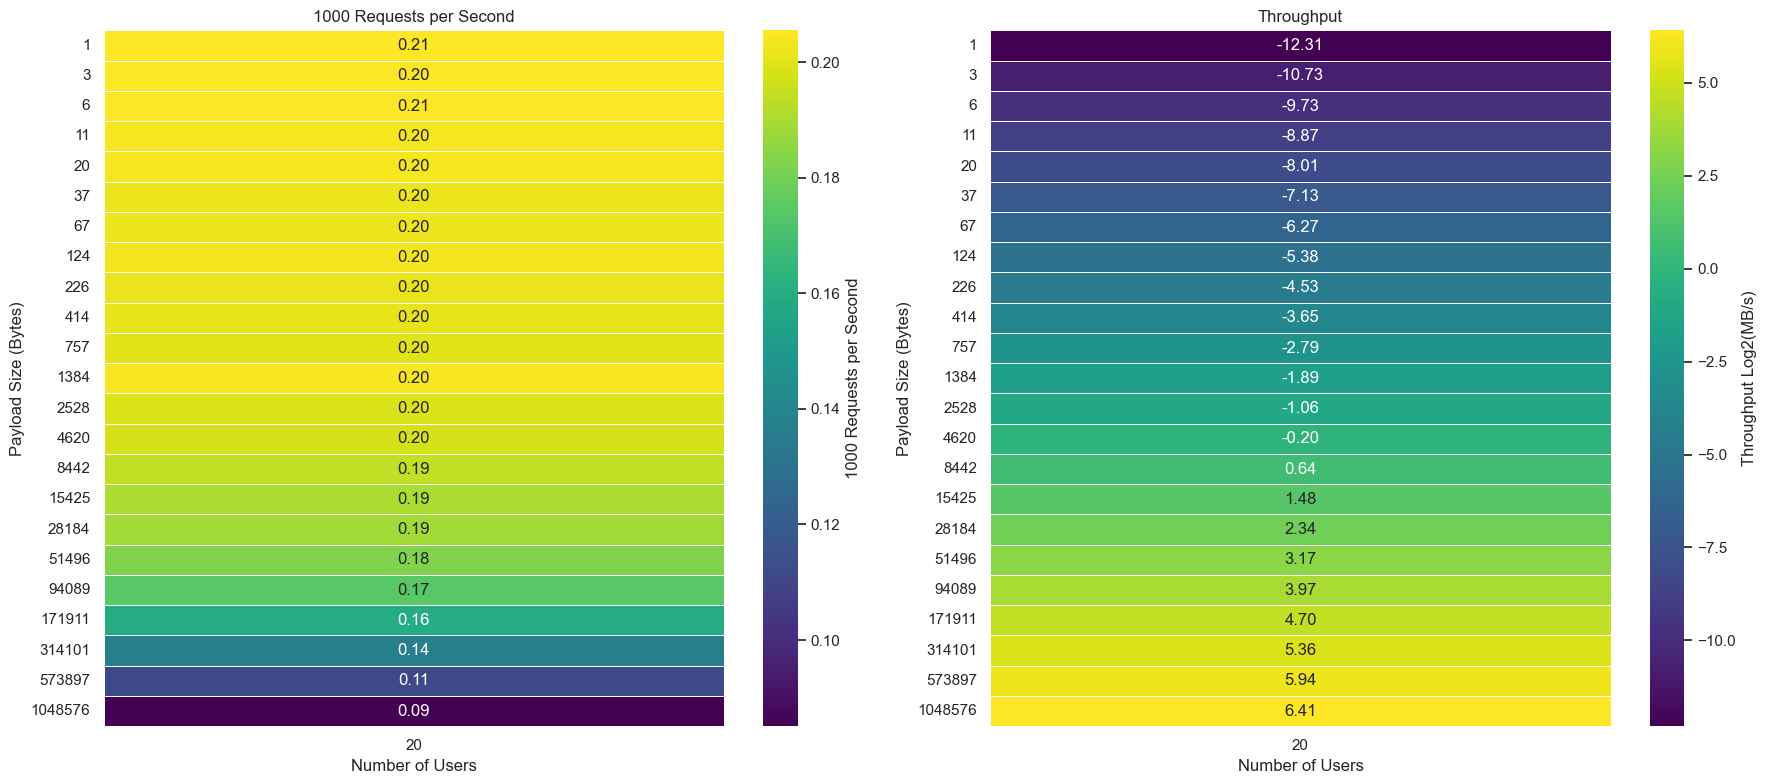

In [38]:
# Add columns for requests per second and requests per second
results_df['requests_per_second'] = results_df['total_requests'] / run_time_seconds / 1000

#results_df['avg_response_time_per_user'] = results_df['avg_response_time'] / results_df['num_users']
results_df['med_response_time_per_user'] = results_df['med_response_time'] / results_df['num_users']
results_df['throughput'] = results_df['total_requests'] / run_time_seconds * results_df['payload_size'] / 1024 / 1024 # MB/s

# Pivot the DataFrames for the heatmaps
heatmap_data_rps = results_df.pivot(index="payload_size", columns="num_users", values="requests_per_second")
heatmap_data_rt = results_df.pivot(index="payload_size", columns="num_users", values="throughput")

# Set up the matplotlib figure
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))

# Draw the heatmap for average response time
sns.heatmap(heatmap_data_rps, cmap="viridis", annot=True, fmt=".2f", linewidths=.5, cbar_kws={"label": "1000 Requests per Second"}, ax=axes[0])
axes[0].set_title('1000 Requests per Second')
axes[0].set_xlabel('Number of Users')
axes[0].set_ylabel('Payload Size (Bytes)')

# Draw the heatmap for requests per second per user
log_heatmap_data = np.log2(heatmap_data_rt + 1e-6)
sns.heatmap(log_heatmap_data, cmap="viridis", annot=True, fmt=".2f", linewidths=.5, cbar_kws={"label": "Throughput Log2(MB/s)"}, ax=axes[1])
axes[1].set_title('Throughput')
axes[1].set_xlabel('Number of Users')
axes[1].set_ylabel('Payload Size (Bytes)')

plt.tight_layout()
plt.show()


In [39]:
print( results_df['num_users'])

0     20
1     20
2     20
3     20
4     20
5     20
6     20
7     20
8     20
9     20
10    20
11    20
12    20
13    20
14    20
15    20
16    20
17    20
18    20
19    20
20    20
21    20
22    20
Name: num_users, dtype: int64


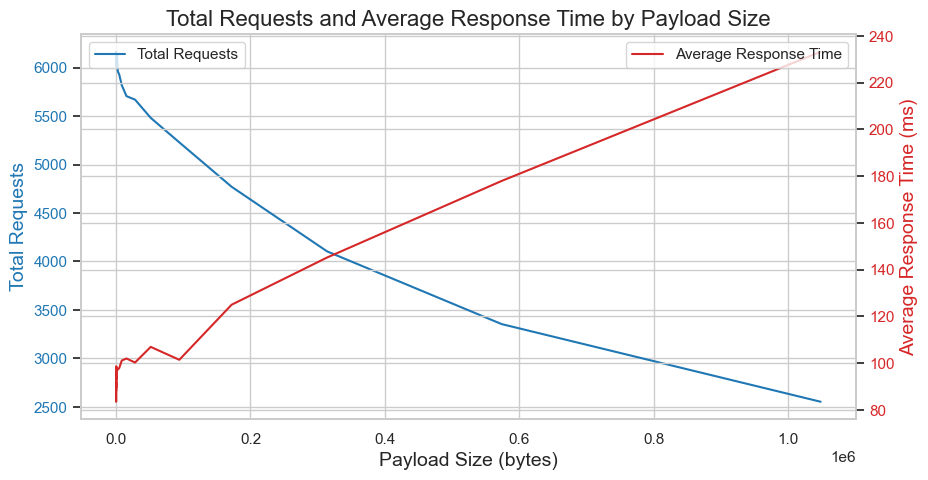

In [42]:
# Assuming 'results_df' is your DataFrame

# First, we will group the data by 'payload_size' and calculate the mean 'total_requests' and 'avg_response_time'.
# This is necessary because your data seems to have multiple entries for each 'payload_size'.
grouped = results_df.groupby('payload_size').mean().reset_index()

# Now let's plot the data
fig, ax1 = plt.subplots(figsize=(10, 5))

# Set the x-axis label
ax1.set_xlabel('Payload Size (bytes)', fontsize=14)

# Plot the 'total_requests' on the left y-axis
ax1.set_ylabel('Total Requests', color='tab:blue', fontsize=14)
ax1.plot(grouped['payload_size'], grouped['total_requests'], color='tab:blue', label='Total Requests')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create a second y-axis to share the same x-axis
ax2 = ax1.twinx()  
ax2.set_ylabel('Average Response Time (ms)', color='tab:red', fontsize=14)  # we already handled the x-label with ax1
ax2.plot(grouped['payload_size'], grouped['avg_response_time'], color='tab:red', label='Average Response Time')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Set the title of the plot
plt.title('Total Requests and Average Response Time by Payload Size', fontsize=16)

# Show a legend
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Show the plot
plt.show()